# Build a Generative AI application using Elasticsearch and OpenAI

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/elastic/elasticsearch-labs/blob/main/notebooks/integrations/openai/openai-KNN-RAG.ipynb)


This notebook demonstrates how to:
- Index the OpenAI Wikipedia vector dataset into Elasticsearch
- Build a simple Gen AI application with Streamlit that retrieves context using Elasticsearch and formulate answers using OpenAI


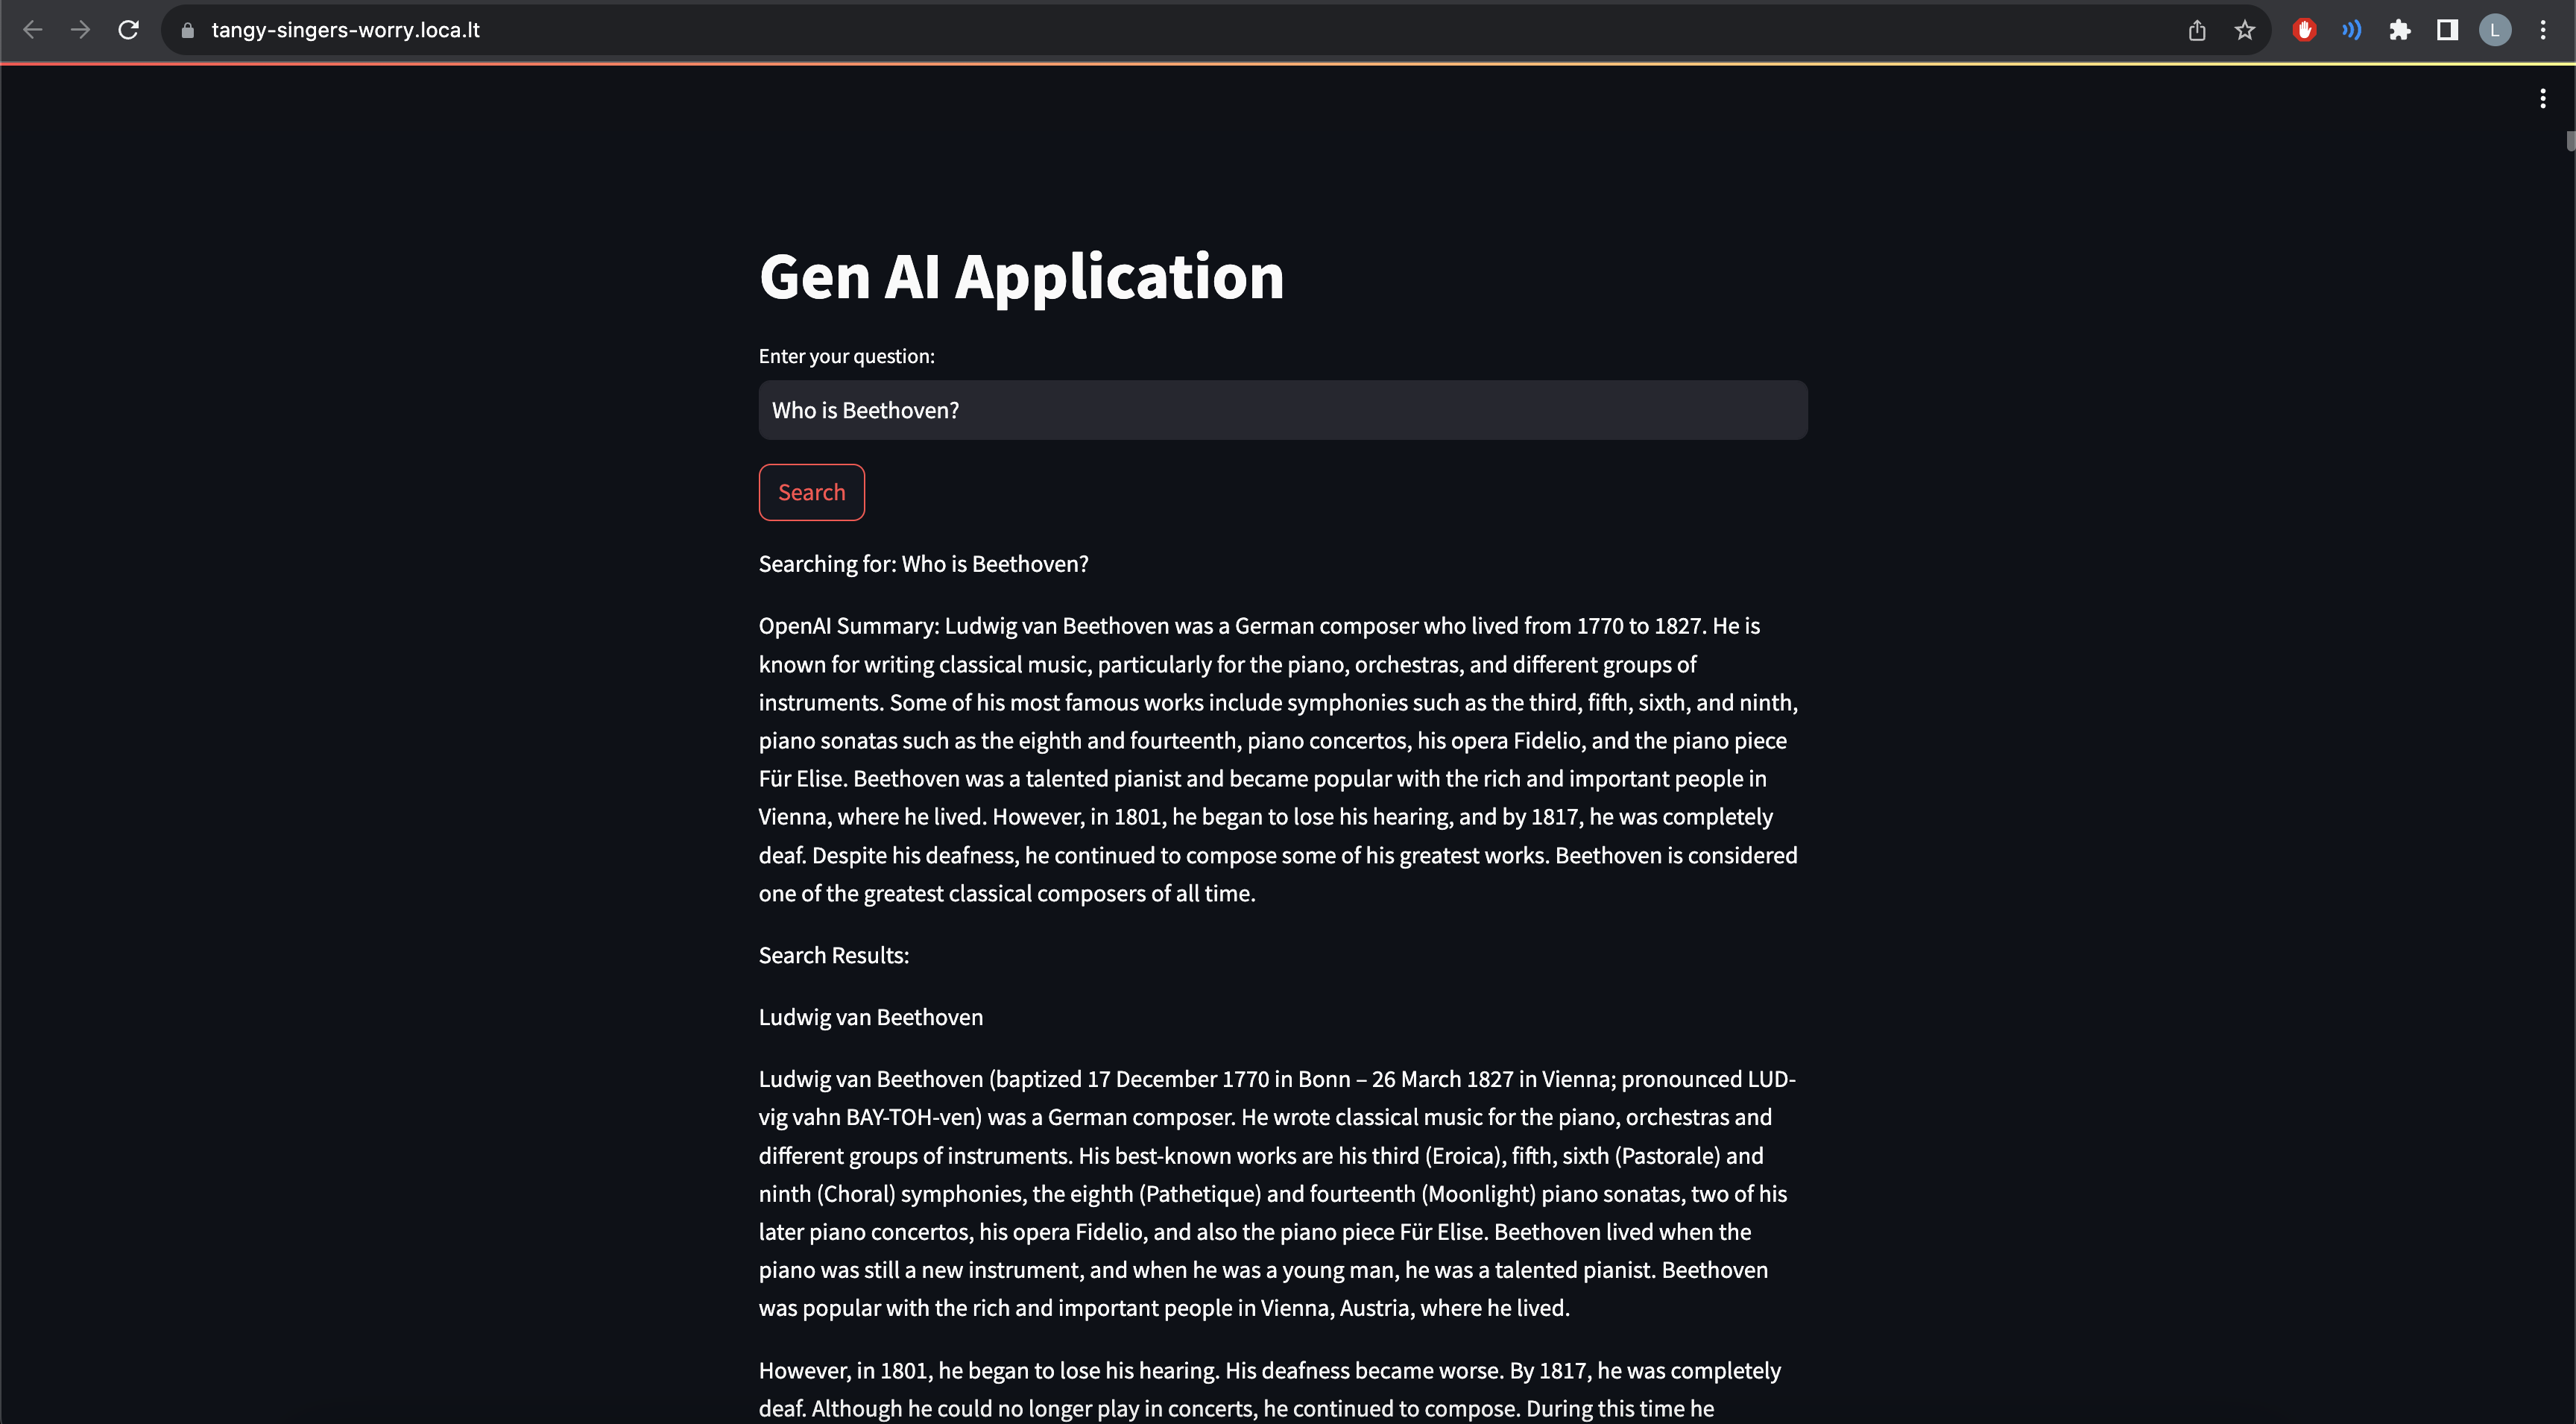

## Install packages and import modules

In [ ]:
# install packages

!python3 -m pip install -qU openai pandas==1.5.3 wget elasticsearch streamlit tqdm

# import modules

import os
from getpass import getpass
from elasticsearch import Elasticsearch, helpers
import wget, zipfile, pandas as pd, json, openai
import streamlit as st
from tqdm.notebook import tqdm

## Connect to Elasticsearch

ℹ️ We're using an Elastic Cloud deployment of Elasticsearch for this notebook.
If you don't already have an Elastic deployment, you can sign up for a free [Elastic Cloud trial](https://cloud.elastic.co/registration?fromURI=%2Fhome).

To connect to Elasticsearch, you need to create a client instance with the Cloud ID and password for your deployment.

Find the Cloud ID for your deployment by going to https://cloud.elastic.co/deployments and selecting your deployment.

In [ ]:
os.environ['es_cloud_id'] = getpass("Elastic deployment Cloud ID")
os.environ['es_password'] = getpass("Elastic deployment Password")

Test the connection with Elasticsearch.

In [ ]:
es_cloud_id = os.environ['es_cloud_id']
es_password = os.environ['es_password']

client = Elasticsearch(
  cloud_id = es_cloud_id,
  basic_auth=("elastic", es_password) # Alternatively use `api_key` instead of `basic_auth`
)

# Test connection to Elasticsearch
print(client.info())

## Configure OpenAI connection

Our example will use OpenAI to formulate an answer, so please provide a valid OpenAI Api Key here.

You can follow [this guide](https://help.openai.com/en/articles/4936850-where-do-i-find-my-secret-api-key) to retrieve your API Key.

Then test the connection with OpenAI and check the model used in this notebook is available.

In [ ]:
os.environ['openai_api_key'] = getpass("OpenAI Api Key")
openai.api_key = os.environ['openai_api_key']
openai.Model.retrieve("text-embedding-ada-002")

## Download the dataset

In this step we download the OpenAI Wikipedia embeddings dataset, and extract the zip file.

In [ ]:
embeddings_url = 'https://cdn.openai.com/API/examples/data/vector_database_wikipedia_articles_embedded.zip'
wget.download(embeddings_url)

with zipfile.ZipFile("vector_database_wikipedia_articles_embedded.zip",
"r") as zip_ref:
    zip_ref.extractall("data")

##  Read CSV file into a Pandas DataFrame

Next we use the Pandas library to read the unzipped CSV file into a DataFrame. This step makes it easier to index the data into Elasticsearch in bulk.

In [ ]:

wikipedia_dataframe = pd.read_csv("data/vector_database_wikipedia_articles_embedded.csv")

## Create index with mapping

Now we need to create an Elasticsearch index with the necessary mappings. This will enable us to index the data into Elasticsearch.

We use the `dense_vector` field type for the `title_vector` and  `content_vector` fields. This is a special field type that allows us to store dense vectors in Elasticsearch.

Later, we'll need to target the `dense_vector` field for kNN search.


In [ ]:
index_mapping= {
    "properties": {
      "title_vector": {
          "type": "dense_vector",
          "dims": 1536,
          "index": "true",
          "similarity": "cosine"
      },
      "content_vector": {
          "type": "dense_vector",
          "dims": 1536,
          "index": "true",
          "similarity": "cosine"
      },
      "text": {"type": "text"},
      "title": {"type": "text"},
      "url": { "type": "keyword"},
      "vector_id": {"type": "long"}

    }
}
client.indices.create(index="wikipedia_vector_index", mappings=index_mapping)

## Index data into Elasticsearch

The following function generates the required bulk actions that can be passed to Elasticsearch's Bulk API, so we can index multiple documents efficiently in a single request.

For each row in the DataFrame, the function yields a dictionary representing a single document to be indexed.

In [ ]:
def dataframe_to_bulk_actions(df):
    for index, row in df.iterrows():
        yield {
            "_index": 'wikipedia_vector_index',
            "_id": row['id'],
            "_source": {
                'url' : row["url"],
                'title' : row["title"],
                'text' : row["text"],
                'title_vector' : json.loads(row["title_vector"]),
                'content_vector' : json.loads(row["content_vector"]),
                'vector_id' : row["vector_id"]
            }
        }

As the dataframe is large, we will index data in batches of `100`. We index the data into Elasticsearch using the Python client's [helpers](https://www.elastic.co/guide/en/elasticsearch/client/python-api/current/client-helpers.html#bulk-helpers) for the bulk API.

In [ ]:
total_documents = len(wikipedia_dataframe)

progress_bar = tqdm(total=total_documents, unit="documents")
success_count = 0

for ok, info in helpers.streaming_bulk(client, actions=dataframe_to_bulk_actions(wikipedia_dataframe), raise_on_error=False, chunk_size=100):
  if ok:
    success_count += 1
  else:
    print(f"Unable to index {info['index']['_id']}: {info['index']['error']}")
  progress_bar.update(1)
  progress_bar.set_postfix(success=success_count)

## Build application with Streamlit

In the following section, you will build a simple interface using streamlit.

This application will display a simple search bar where an user can ask a question. Elasticsearch is used to retrieve the relevant documents (context) matching the question then OpenAI formulate an answer using the context.

Install the dependency to access the application once running.

In [ ]:
!npm install localtunnel

Create application

In [ ]:
%%writefile app.py

import os
import streamlit as st
import openai
from elasticsearch import Elasticsearch


# Elastic Cloud
es_cloud_id = os.environ['es_cloud_id']
es_password = os.environ['es_password']

# OpenAI
openai.api_key = os.environ['openai_api_key']

# Define model
EMBEDDING_MODEL = "text-embedding-ada-002"

# Connect to Elasticsearch
client = Elasticsearch(
  cloud_id = es_cloud_id,
  basic_auth=("elastic", es_password) # Alternatively use `api_key` instead of `basic_auth`
)

def openai_summarize(query, response):
    context = response['hits']['hits'][0]['_source']['text']
    summary = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": "Answer the following question:" + query + "by using the following text: " + context},
        ]
    )
    return summary.choices[0].message.content


def search_es(query):
    # Create embedding
    question_embedding = openai.Embedding.create(input=query, model=EMBEDDING_MODEL)

    # Define Elasticsearch query
    response = client.search(
    index = "wikipedia_vector_index",
    knn={
        "field": "content_vector",
        "query_vector":  question_embedding["data"][0]["embedding"],
        "k": 10,
        "num_candidates": 100
        }
    )
    return response


def main():
    st.title("Gen AI Application")

    # Input for user search query
    user_query = st.text_input("Enter your question:")

    if st.button("Search"):
        if user_query:

            st.write(f"Searching for: {user_query}")
            result = search_es(user_query)

            # print(result)
            openai_summary = openai_summarize(user_query, result)
            st.write(f"OpenAI Summary: {openai_summary}")

            # Display search results
            if result['hits']['total']['value'] > 0:
                st.write("Search Results:")
                for hit in result['hits']['hits']:
                    st.write(hit['_source']['title'])
                    st.write(hit['_source']['text'])
            else:
                st.write("No results found.")

if __name__ == "__main__":
    main()



### Run the application

Run the application and check your IP for the tunneling

In [ ]:
!streamlit run app.py &> /content/app.log & curl ipv4.icanhazip.com

### Create the tunnel to access it from anywhere

Run the tunnel and use the link below to connect to the tunnel.

Use the IP from the previous step to connect to the application

In [ ]:
!npx localtunnel --port 8501

Success you build your first Gen AI Application.

You can try it by asking question such as "Who is Beethoven?" or "What is football?" and see the answers.

## Next steps

Now you know how to quickly put together an interface that allows you to ask questions and get answer from a specific dataset, in this notebook example, wikipedia.

You can adapt this example to use your own dataset, and use the streamlit application as a blueprint for integrating with your own application.